# Clustering Analysis

We encode the sentences with BERT and use the T-SNE algorithm to visualize them in 2 dimension.

In [1]:
import sys
sys.path.append('..')
import transformers
import torch
import torchvision
from mm_models import DenseNetBertMMModel, DenseNetBertMMCateModel, ImageOnlyModel, TextOnlyModel, DenseNetBertMMModelSimpleConcat, DenseNetBertMMModelConcat4

## Experiment Configurations

In [2]:
task = ['task1', 'task2'][0]
use_cate = True
selected = True
vis_vec = True

file_str = '{}{}{}'.format(task, '_cate' if use_cate else '', '_selected' if selected else '')
cate_root = 'CrisisMMD_extra_selected' if selected else 'CrisisMMD_extra'
model_path = 'W:/models/crisismmd-trained-final/full_{}/best.pt'.format(file_str)
model_init = DenseNetBertMMCateModel if use_cate else DenseNetBertMMModel
data_phase = ['train', 'dev', 'test'][2]
if not selected:
    cate_dim = 152
else:
    if task == 'task1':
        cate_dim = 21
    else:
        cate_dim = 20

"""
    Create argument
"""

class Args:
    pass


opt = Args()
opt.gpu = 0
opt.batch_size = 1
opt.max_dataset_size = 2000
# opt.max_dataset_size = 100
opt.crop_size = 230
opt.load_size = 224
opt.debug = False
opt.device = 'cuda'
opt.model_to_load = model_path

Execute the sentence encoder. The model to use from the Transformers library is up to the liberty of the user.

Source: https://datascience.stackexchange.com/questions/62658/how-to-get-sentence-embedding-using-bert

## Load the dataset

In [3]:
from crisismmd_dataset import CrisisMMDataset
from args import get_args
import torch
from torch.utils.data import DataLoader

task_str = 'task1' if task == 'task1' else 'task2_merged'
dataset = CrisisMMDataset()
dataset.initialize(opt, data_phase, task=task_str, no_transform=True, consistent_only=True, use_cate=use_cate, category_root=cate_root) # TODO: Experiment with params here!
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

[*] 1534 samples loaded.


In [4]:
labels_task1 = {
    'not_informative': 0,
    'informative': 1
}

labels_task2 = {
    'infrastructure_and_utility_damage': 0,
    'not_humanitarian': 1,
    'other_relevant_information': 2,
    'rescue_volunteering_or_donation_effort': 3,
    'vehicle_damage': 0,
    'affected_individuals': 4,
    'injured_or_dead_people': 4,
    'missing_or_found_people': 4,
}
OUTPUT_SIZE = 2 if task == 'task1' else 5

labels_mapping = labels_task1 if task == 'task1' else labels_task2


# Load the model

In [5]:
if use_cate:
    model = model_init(num_class=2 if task == 'task1' else 6, save_dir='.', dim_cate_repr=cate_dim).to(opt.device)
else:
    model = model_init(num_class=2 if task == 'task1' else 6, save_dir='.').to(opt.device)
# model = DenseNetBertMMModel(num_class=OUTPUT_SIZE, save_dir='.').to(opt.device)
model.load(opt.model_to_load)
model.return_repr = True

Using cache found in C:\Users\PaulChen/.cache\torch\hub\pytorch_vision_v0.8.0
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Retrieving representation
Feed them into the Transformers model.

In [6]:
# import os
# torch.cuda.set_device(0)
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from tqdm import tqdm
model.eval()
outputs = []
labels = []
for idx, data in tqdm(enumerate(dataloader), total=len(dataloader)):
    x = (data['image'].to(opt.device),
        {k: v.to(opt.device)
        for k, v in data['text_tokens'].items()},
        data['category_vector'].to(opt.device))

    labels.append(data['label'].item()) # TODO: Experiment with different labels here

    if vis_vec:
        outputs.append(x[2].cpu().numpy())
    else:
        repr = model(x)
        result = repr.detach().cpu().numpy()
        outputs.append(result)


  1%|          | 11/1534 [00:00<00:36, 41.41it/s]E:\anaconda\envs\11777\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1534/1534 [00:25<00:00, 59.10it/s]


## Visualization with T-SNE

In [7]:
embedding_dim = outputs[0].shape[1]
print("Vector dimension: {}".format(embedding_dim))

Vector dimension: 21


In [8]:
import numpy as np
from tsne import tsne
from matplotlib import pyplot as plt
output_np = np.array(outputs).squeeze(1)
Y = tsne(output_np, 2, embedding_dim, 30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1534...
Computing P-values for point 500 of 1534...
Computing P-values for point 1000 of 1534...
Computing P-values for point 1500 of 1534...
Mean value of sigma: 1.063596
Iteration 10: error is 19.401758
Iteration 20: error is 16.644445
Iteration 30: error is 14.952765
Iteration 40: error is 14.442574
Iteration 50: error is 14.328249
Iteration 60: error is 14.306088
Iteration 70: error is 14.297139
Iteration 80: error is 14.294480
Iteration 90: error is 14.296650
Iteration 100: error is 14.271674
Iteration 110: error is 1.768381
Iteration 120: error is 1.397592
Iteration 130: error is 1.205889
Iteration 140: error is 1.091567
Iteration 150: error is 1.017816
Iteration 160: error is 0.966474
Iteration 170: error is 0.928741
Iteration 180: error is 0.900113
Iteration 190: error is 0.877846
Iteration 200: error is 0.860187
Iteration 210: error is 0.845896
Iteration 220: error is 0.834004

Saving to ../visuals/tsne_task1_cate_selected_test_500_vec.png


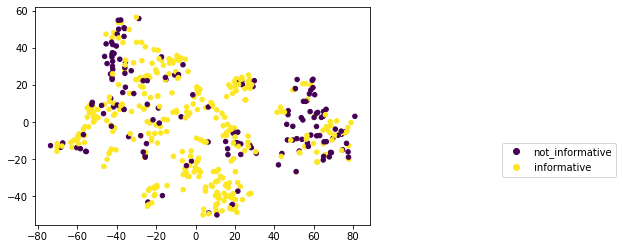

<Figure size 432x288 with 0 Axes>

In [12]:


data_points_to_plot = 500


inverse_task1 = {
     0: 'not_informative',
     1: 'informative'
}

inverse_task2 = {
    0: 'infrastructure_and_utility_damage & vehicle_damage',
    1: 'not_humanitarian',
    2: 'other_relevant_information',
    3: 'rescue_volunteering_or_donation_effort',
    4: 'affected_individuals & injured_or_dead_people & missing_or_found_people',
}

inverse_map = inverse_task1 if task == 'task1' else inverse_task2

fig = plt.figure()
# plt.title("Category Features")
plt.title("")

label_names = [inverse_map[label] for label in labels]
scatter = plt.scatter(Y[:data_points_to_plot, 0], Y[:data_points_to_plot, 1], s=20, label=label_names, c=labels[:data_points_to_plot])

if task == 'task1':
    # plt.legend(loc='lower center', handles=scatter.legend_elements()[0], labels=inverse_map.values())
    plt.legend(loc='right', handles=scatter.legend_elements()[0], labels=inverse_map.values(), bbox_to_anchor=(1.75, 0.3))
    pass
elif task == 'task2':
    plt.legend(loc='right', handles=scatter.legend_elements()[0], labels=inverse_map.values(), bbox_to_anchor=(1, 1.3))
    pass
else:
    raise NotImplemented

# file name: tsne-task-phase-model-numberofpoints
filename = '../visuals/tsne_{}_{}_{}{}.png'.format(file_str, data_phase, data_points_to_plot, '_vec' if vis_vec else '')
print("Saving to {}".format(filename))
plt.savefig(filename)
plt.show()
plt.clf()

In [ ]:
max(labels)

1

In [10]:
task

'task1'